# Convex Optimization in Julia

## Madeleine Udell | ISMP 2015

## Convex.jl team

* [Convex.jl](https://github.com/cvxgrp/Convex.jl): Madeleine Udell, Karanveer Mohan, David Zeng, Jenny Hong

## Collaborators/Inspiration:

* [CVX](http://www.cvxr.com): Michael Grant, Stephen Boyd
* [CVXPY](https://github.com/cvxgrp/cvxpy): Steven Diamond, Eric Chu, Stephen Boyd
* [JuliaOpt](https://github.com/JuliaOpt): Miles Lubin, Iain Dunning, Joey Huchette

In [ ]:
# initial package installation
Pkg.add("Convex")
Pkg.add("SCS")
Pkg.add("Gadfly")
Pkg.add("Interact")

In [28]:
# Make the Convex.jl module available
using Convex
using SCS # first order splitting conic solver [O'Donoghue et al., 2014]
set_default_solver(SCSSolver(verbose=0)) # could also use Gurobi, Mosek, CPLEX, ...

# Generate random problem data
m = 50;  n = 100
A = randn(m, n)
x♮ = sprand(n, 1, .5) # true (sparse nonnegative) parameter vector
noise = .1*randn(m)    # gaussian noise
b = A*x♮ + noise      # noisy linear observations

# Create a (column vector) variable of size n.
x = Variable(n)

# nonnegative elastic net with regularization
λ = 1
μ = 1
problem = minimize(norm(A * x - b)^2 + λ*norm(x)^2 + μ*norm(x, 1), 
                   x >= 0)

# Solve the problem by calling solve!
solve!(problem)

println("problem status is ", problem.status) # :Optimal, :Infeasible, :Unbounded etc.
println("optimal value is ", problem.optval)

problem status is Optimal
optimal value is 43.82521706423979


Slider{Float64}([Input{Float64}] 2.5,"λ",2.5,0.0:0.1:5.0)

Slider{Float64}([Input{Float64}] 2.5,"mu",2.5,0.0:0.1:5.0)

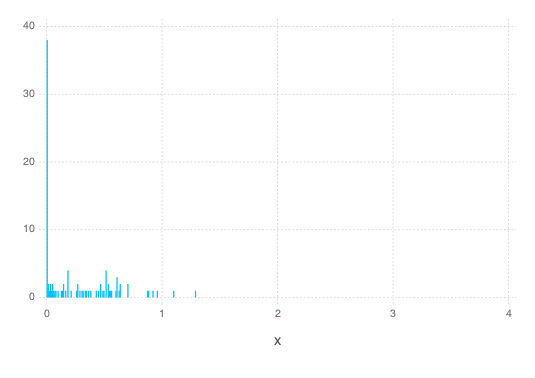

In [29]:
using Gadfly, Interact
@manipulate for λ=0:.1:5, mu=0:.1:5
    problem = minimize(norm(A * x - b)^2 + λ*norm(x)^2 + μ*norm(x, 1), 
                   x >= 0)
    solve!(problem)
    plot(x=x.value, Geom.histogram(minbincount = 20), 
             Scale.x_continuous(minvalue=0, maxvalue=3.5))#, Scale.y_continuous(minvalue=0, maxvalue=6))
end

# Quick convex prototyping

## Variables

In [30]:
# Scalar variable
x = Variable()

Variable of
size: (1, 1)
sign: NoSign()
vexity: AffineVexity()

In [31]:
# (Column) vector variable
y = Variable(4)

Variable of
size: (4, 1)
sign: NoSign()
vexity: AffineVexity()

In [32]:
# Matrix variable
Z = Variable(4, 4)

Variable of
size: (4, 4)
sign: NoSign()
vexity: AffineVexity()

# Expressions

Convex.jl allows you to use a [wide variety of functions](http://convexjl.readthedocs.org/en/latest/operations.html) on variables and on expressions to form new expressions.

In [34]:
x + 2x

AbstractExpr with
head: +
size: (1, 1)
sign: NoSign()
vexity: AffineVexity()


In [35]:
e = y[1] + logdet(Z) + sqrt(x) + minimum(y)

AbstractExpr with
head: +
size: (1, 1)
sign: NoSign()
vexity: ConcaveVexity()


### Examine the expression tree

In [38]:
e.children[2]

AbstractExpr with
head: logdet
size: (1, 1)
sign: NoSign()
vexity: ConcaveVexity()


# Constraints

A constraint is convex if convex combinations of feasible points are also feasible. Equivalently, feasible sets are convex sets.

In other words, convex constraints are of the form

* `convexExpr <= 0`
* `concaveExpr >= 0`
* `affineExpr == 0`

In [39]:
x <= 0

Constraint:
<= constraint
lhs: Variable of
size: (1, 1)
sign: NoSign()
vexity: AffineVexity()
rhs: 0
vexity: AffineVexity()

In [40]:
x^2 <= sum(y)

Constraint:
<= constraint
lhs: AbstractExpr with
head: qol_elem
size: (1, 1)
sign: Positive()
vexity: ConvexVexity()

rhs: AbstractExpr with
head: sum
size: (1, 1)
sign: NoSign()
vexity: AffineVexity()

vexity: ConvexVexity()

In [42]:
M = Z 
for i = 1:length(y)
    M += rand(size(Z))*y[i]
end
M ⪰ 0

Constraint:
sdp constraint
expression: AbstractExpr with
head: +
size: (4, 4)
sign: NoSign()
vexity: AffineVexity()



# Problems

In [12]:
x = Variable()
y = Variable(4)
objective = 2*x + 1 - sqrt(sum(y))
constraint = x >= maximum(y)
p = minimize(objective, constraint)

Problem:
minimize AbstractExpr with
head: +
size: (1, 1)
sign: NoSign()
vexity: ConvexVexity()

subject to
Constraint:
>= constraint
lhs: Variable of
size: (1, 1)
sign: NoSign()
vexity: AffineVexity()
rhs: AbstractExpr with
head: maximum
size: (1, 1)
sign: NoSign()
vexity: ConvexVexity()

vexity: ConvexVexity()
current status: not yet solved

In [43]:
# solve the problem
solve!(p)
p.status

:Optimal

In [44]:
x.value

In [45]:
# can evaluate expressions directly
evaluate(objective)

1x1 Array{Float64,2}:
 0.500004

## Pass to solver

call a `MathProgBase` solver suited for your problem class

* see the [list of Convex.jl operations](http://convexjl.readthedocs.org/en/latest/operations.html) to find which cones you're using
* see the [list of solvers](http://www.juliaopt.org/) for an up-to-date list of solvers and which cones they support

to solve problem using a different solver, just import the solver package and pass the solver to the `solve!` method: eg

    using Mosek
    solve!(p, MosekSolver())

## Warmstart

In [23]:
# Generate random problem data
m = 50;  n = 100
A = randn(m, n)
x♮ = sprand(n, 1, .5) # true (sparse nonnegative) parameter vector
noise = .1*randn(m)    # gaussian noise
b = A*x♮ + noise      # noisy linear observations

# Create a (column vector) variable of size n.
x = Variable(n)

# nonnegative elastic net with regularization
λ = 1
μ = 1
problem = minimize(norm(A * x - b)^2 + λ*norm(x)^2 + μ*norm(x, 1), 
                   x >= 0)
@time solve!(problem)
λ = 1.5
@time solve!(problem, warmstart = true)

elapsed time: 0.021169205 seconds (3092632 bytes allocated)
elapsed time: 0.0075224 seconds (3081120 bytes allocated)


# DCP examples

In [17]:
# affine
x = Variable(4)
y = Variable (2)
sum(x) + y[2]

AbstractExpr with
head: +
size: (1, 1)
sign: NoSign()
vexity: AffineVexity()


In [18]:
2*maximum(x) + 4*sum(y) - sqrt(y[1] + x[1]) - 7 * minimum(x[2:4])

AbstractExpr with
head: +
size: (1, 1)
sign: NoSign()
vexity: ConvexVexity()


In [19]:
# not dcp compliant
log(x) + x^2

AbstractExpr with
head: +
size: (4, 1)
sign: NoSign()
vexity: NotDcp()


In [20]:
# $f$ is convex increasing and $g$ is convex
square(pos(x))

AbstractExpr with
head: qol_elem
size: (4, 1)
sign: Positive()
vexity: ConvexVexity()


In [21]:
# $f$ is convex decreasing and $g$ is concave 
invpos(sqrt(x))

AbstractExpr with
head: qol_elem
size: (4, 1)
sign: Positive()
vexity: ConvexVexity()


In [22]:
# $f$ is concave increasing and $g$ is concave 
sqrt(sqrt(x))

AbstractExpr with
head: geomean
size: (4, 1)
sign: Positive()
vexity: ConcaveVexity()
